In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import interp

In [2]:
iris = pd.read_csv("~/DATA/Iris.csv")  # Load the data
iris.head()  # Peek at the data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
#All-in-one:
X = iris[iris.columns[1:5]]
y = iris[iris.columns[5]]
X=np.array(X)
y=np.array(y)

In [4]:
# encoder = OneHotEncoder(sparse=False)
# y=encoder.fit_transform(y.reshape(-1,1)) # encode the label

sc = StandardScaler()  # Load the standard scaler
sc.fit(X)  # Compute the mean and standard deviation of the feature data
X_scaled = sc.transform(X)  # Scale the feature data to be of mean 0 and variance 1

# Split the dataset into 30% testing, and 70% training 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, random_state=1)

In [15]:
help(model.predict)

Help on method predict in module sklearn.linear_model.base:

predict(X) method of sklearn.linear_model.logistic.LogisticRegression instance
    Predict class labels for samples in X.
    
    Parameters
    ----------
    X : array_like or sparse matrix, shape (n_samples, n_features)
        Samples.
    
    Returns
    -------
    C : array, shape [n_samples]
        Predicted class label per sample.



In [14]:
help(model.predict_probaba)

Help on method predict_proba in module sklearn.linear_model.logistic:

predict_proba(X) method of sklearn.linear_model.logistic.LogisticRegression instance
    Probability estimates.
    
    The returned estimates for all classes are ordered by the
    label of classes.
    
    For a multi_class problem, if multi_class is set to be "multinomial"
    the softmax function is used to find the predicted probability of
    each class.
    Else use a one-vs-rest approach, i.e calculate the probability
    of each class assuming it to be positive using the logistic function.
    and normalize these values across all the classes.
    
    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
    
    Returns
    -------
    T : array-like, shape = [n_samples, n_classes]
        Returns the probability of the sample for each class in the model,
        where classes are ordered as they are in ``self.classes_``.



In [5]:
model = LogisticRegression()  # Load our classifier
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
y_score = model.predict_proba(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


# How do we evaluate multi-class models?
[sci-kit learn metrics module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

We can use
- accuracy
- confusion matrix
- precision - recall curve
- sensitivity - specificity curve
- F1 metric
- AUC

However some metrics can only be calculated on binary classification tasks so we must take a One Vs Rest approach and calculate the metric for each class. Then we must some how take an average.

There are two strategies for taking an average. [Micro and Macro](https://datascience.stackexchange.com/a/24051).



## Example

Iris data set  
How many classes are there?

In [6]:
metrics.accuracy_score(y_test, y_predict)

0.8222222222222222

In [7]:
metrics.confusion_matrix(y_test, y_predict)

array([[14,  0,  0],
       [ 0, 11,  7],
       [ 0,  1, 12]])

In [16]:
model.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [8]:
metrics.multilabel_confusion_matrix(y_test, y_predict)

array([[[31,  0],
        [ 0, 14]],

       [[26,  1],
        [ 7, 11]],

       [[25,  7],
        [ 1, 12]]])

In [9]:
np.unique(y_test)

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

(0.0, 1.05)

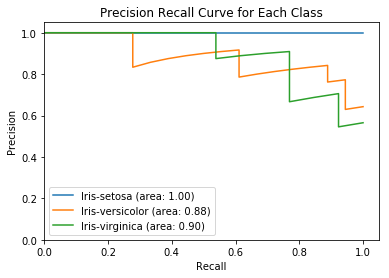

In [10]:
precisions = {}
recalls = {}
for idx, c in enumerate(model.classes_):
    precisions[c], recalls[c], _ = metrics.precision_recall_curve(y_test==c, y_score[:,idx])

    plt.plot(recalls[c], precisions[c],
             label='%s (area: %.2f)' % (c, metrics.average_precision_score(y_test==c, y_score[:,idx])))
    
plt.legend(loc="lower left")
plt.title('Precision Recall Curve for Each Class')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])

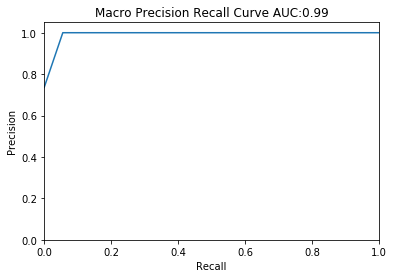

0.9926673567977916


In [11]:
counts = {c: np.sum(y_test==c) for c in model.classes_}
norm_counts = {c: v/sum(counts.values()) for c, v in counts.items()}

# First aggregate all recalls
all_rec = np.unique(np.concatenate([recalls[c] for c in model.classes_]))

# Then interpolate all precision-recall curves at this points
mean_pre = np.zeros_like(all_rec)
for c in model.classes_:
    mean_pre += interp(all_rec, recalls[c], precisions[c])

# Finally average it and compute AUC
mean_pre /= len(model.classes_)

recalls["macro"] = all_rec
precisions["macro"] = mean_pre
macro_auc = metrics.auc(recalls["macro"], precisions["macro"])

plt.plot(recalls['macro'], precisions['macro'])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro Precision Recall Curve AUC:%.2f' % macro_auc)
plt.show()

print(macro_auc)

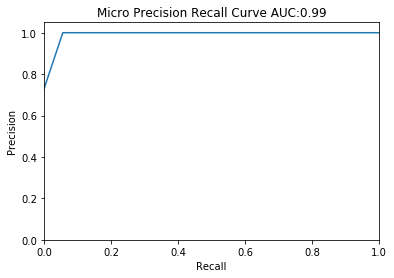

0.9925427497891266


In [12]:
micro_pre = np.zeros_like(all_rec)
for c in model.classes_:
    micro_pre += interp(all_rec, recalls[c], precisions[c]) * norm_counts[c]
    
recalls["micro"] = all_rec
precisions["micro"] = micro_pre
micro_auc = metrics.auc(recalls["micro"], precisions["micro"])

plt.plot(recalls['micro'], precisions['micro'])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro Precision Recall Curve AUC:%.2f' % micro_auc)
plt.show()

print(micro_auc)

# Exercise

Calculate the micro f1 score of a random forest model trained on the [crowdsource mapping](https://archive.ics.uci.edu/ml/datasets/Crowdsourced+Mapping) data set